# Realistic Garbage Fragment Superposition

This notebook demonstrates techniques for realistically placing garbage fragments onto street photos.
Each function is modular and can be experimented with independently.

## Key Techniques Covered:
1. Background segmentation (finding suitable placement areas)
2. Fragment preparation (cleaning and masking)
3. Geometric alignment (perspective, scale, rotation)
4. Photometric matching (lighting, shadows, colors)
5. Blending techniques (seamless integration)

## Learning Path:
- Start with simple functions and visualize each step
- Experiment with parameters to understand their effects
- Combine techniques for increasingly realistic results

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
from typing import Tuple, List, Optional, Dict
from dataclasses import dataclass
from pathlib import Path
import json

# For more advanced features (optional - will gracefully degrade if not available)
try:
    from sklearn.cluster import KMeans

    SKLEARN_AVAILABLE = True
except ImportError:
    SKLEARN_AVAILABLE = False
    print("sklearn not available - some color analysis features will be limited")

## 1. Background Analysis and Segmentation

These functions help identify suitable areas for placing garbage fragments.
We want to avoid placing objects on sky, people, vehicles, etc.

In [76]:
image_base = Path(
    "/Users/hariomnarang/Desktop/personal/roads/mapillary_downloader/data/samples"
)
all_images = list(image_base.rglob("*.jpg"))
random.shuffle(all_images)
images = all_images[:10]

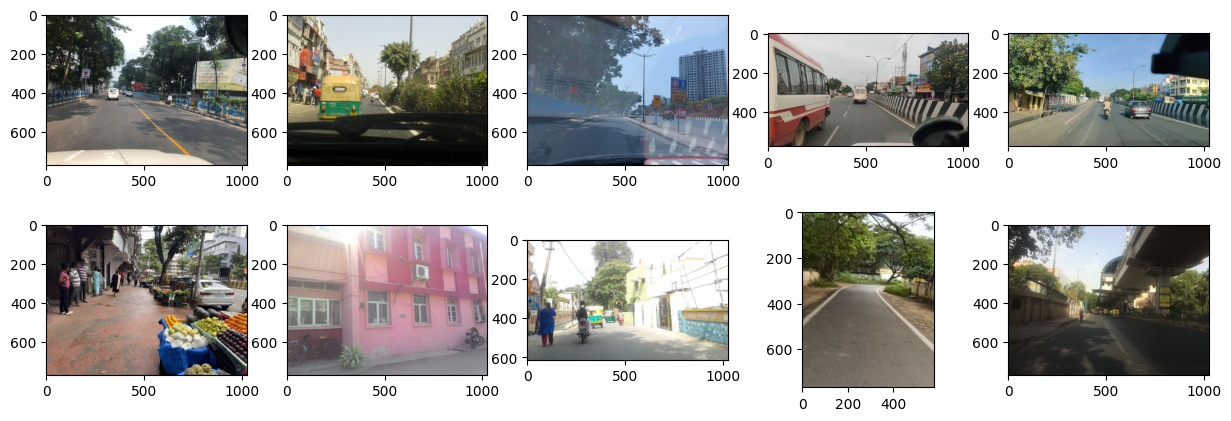

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
for a, i in zip(axs.flat, images):
    a.imshow(plt.imread(i))
plt.show()

In [ ]:
class BackgroundAnalyzer:
    """
    Analyzes background images to find suitable placement areas

    Input: Street photo (numpy array, BGR format)
    Output: Mask indicating good placement areas
    """

    @staticmethod
    def simple_color_segmentation(
        image: np.ndarray, visualize: bool = True
    ) -> np.ndarray:
        """
        Simple color-based segmentation to find neutral backgrounds

        Args:
            image: Input street photo (H, W, 3) in BGR format
            visualize: Whether to show intermediate results

        Returns:
            Binary mask where 1 = good placement area, 0 = avoid
        """
        # Convert to HSV for better color analysis
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, w = image.shape[:2]

        # Create mask for different surface types
        placement_mask = np.zeros((h, w), dtype=np.uint8)

        # Road colors (gray, dark tones)
        # HSV ranges: roads are typically low saturation, medium-low value
        road_mask = cv2.inRange(hsv, (0, 0, 0), (180, 40, 255))

        # Ground/dirt colors (brown, tan, yellow tones)
        ground_mask1 = cv2.inRange(hsv, (10, 30, 80), (30, 150, 200))  # Brown/tan
        ground_mask2 = cv2.inRange(hsv, (20, 50, 100), (35, 200, 255))  # Yellow/tan
        ground_mask = cv2.bitwise_or(ground_mask1, ground_mask2)

        # Grass/vegetation (green tones, but not too bright)
        grass_mask = cv2.inRange(hsv, (40, 30, 50), (80, 150, 180))

        # Combine all suitable surfaces
        placement_mask = cv2.bitwise_or(
            cv2.bitwise_or(road_mask, ground_mask), grass_mask
        )

        # Remove small noise regions
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        placement_mask = cv2.morphologyEx(placement_mask, cv2.MORPH_OPEN, kernel)

        # Fill small holes
        placement_mask = cv2.morphologyEx(placement_mask, cv2.MORPH_CLOSE, kernel)

        if visualize:
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))

            # Original image
            axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[0, 0].set_title("Original Image")
            axes[0, 0].axis("off")

            # Individual masks
            axes[0, 1].imshow(road_mask, cmap="gray")
            axes[0, 1].set_title("Road Areas")
            axes[0, 1].axis("off")

            axes[0, 2].imshow(ground_mask, cmap="gray")
            axes[0, 2].set_title("Ground Areas")
            axes[0, 2].axis("off")

            axes[1, 0].imshow(grass_mask, cmap="gray")
            axes[1, 0].set_title("Grass Areas")
            axes[1, 0].axis("off")

            axes[1, 1].imshow(placement_mask, cmap="gray")
            axes[1, 1].set_title("Combined Placement Areas")
            axes[1, 1].axis("off")

            # Overlay on original
            overlay = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()
            overlay[placement_mask > 0] = [0, 255, 0]  # Green overlay
            axes[1, 2].imshow(
                cv2.addWeighted(
                    cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0
                )
            )
            axes[1, 2].set_title("Placement Areas Overlay")
            axes[1, 2].axis("off")

            plt.tight_layout()
            plt.show()

        return placement_mask

    @staticmethod
    def detect_sky_region(image: np.ndarray, visualize: bool = True) -> np.ndarray:
        """
        Detect sky regions to exclude them from placement

        Args:
            image: Input image
            visualize: Show detection results

        Returns:
            Binary mask where 1 = sky, 0 = not sky
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Sky is typically blue with high saturation and value
        sky_mask = cv2.inRange(hsv, (100, 50, 100), (130, 255, 255))

        # Also check for bright areas in upper part of image (likely sky)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h = image.shape[0]
        upper_bright = np.zeros_like(gray)
        upper_bright[: h // 3, :] = gray[: h // 3, :]  # Top third of image
        _, bright_mask = cv2.threshold(upper_bright, 200, 255, cv2.THRESH_BINARY)

        # Combine both detections
        sky_mask = cv2.bitwise_or(sky_mask, bright_mask)

        # Clean up the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        sky_mask = cv2.morphologyEx(sky_mask, cv2.MORPH_CLOSE, kernel)

        if visualize:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Original Image")
            axes[0].axis("off")

            axes[1].imshow(sky_mask, cmap="gray")
            axes[1].set_title("Sky Detection")
            axes[1].axis("off")

            # Show exclusion overlay
            overlay = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()
            overlay[sky_mask > 0] = [255, 0, 0]  # Red overlay for excluded areas
            axes[2].imshow(
                cv2.addWeighted(
                    cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 0.7, overlay, 0.3, 0
                )
            )
            axes[2].set_title("Sky Exclusion Overlay")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

        return sky_mask

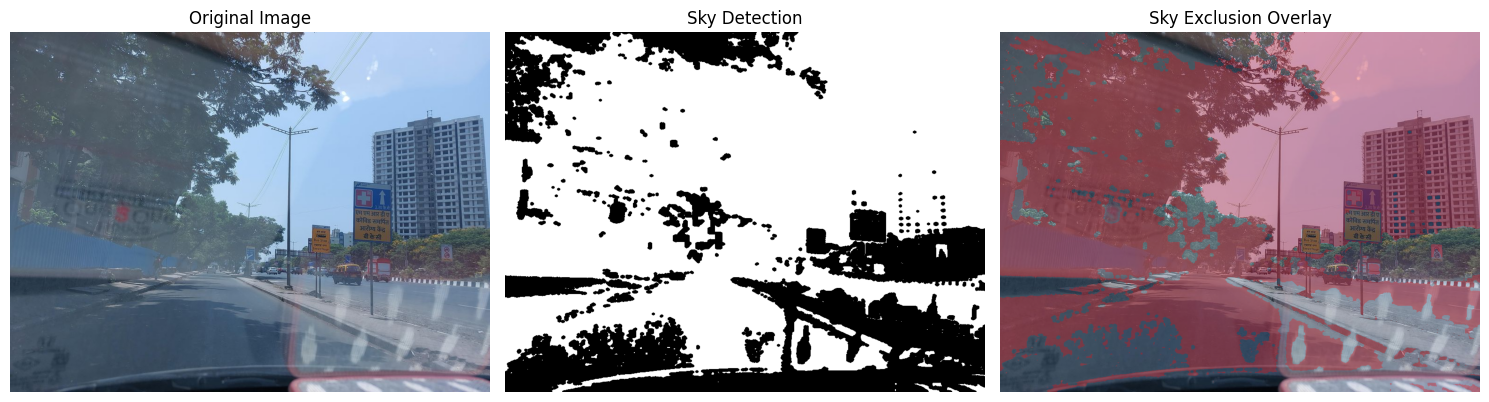

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], shape=(768, 1024), dtype=uint8)

In [9]:
BackgroundAnalyzer.detect_sky_region(cv2.imread(images[2]), visualize=True)

## 2. Fragment Preparation

These functions prepare garbage fragments for placement by removing backgrounds
and creating clean masks.

In [ ]:
class FragmentProcessor:
    """
    Processes garbage fragment images for realistic placement

    Input: Fragment image with background
    Output: Clean fragment with alpha mask
    """

    @staticmethod
    def simple_background_removal(
        fragment: np.ndarray, method: str = "grabcut", visualize: bool = True
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Remove background from garbage fragment

        Args:
            fragment: Fragment image (H, W, 3) BGR format
            method: 'grabcut', 'threshold', or 'manual_mask'
            visualize: Show processing steps

        Returns:
            (clean_fragment, alpha_mask) where alpha_mask: 0=background, 255=foreground
        """
        if method == "grabcut":
            return FragmentProcessor._grabcut_background_removal(fragment, visualize)
        elif method == "threshold":
            return FragmentProcessor._threshold_background_removal(fragment, visualize)
        else:
            # For manual mask, assume user will provide it
            print("Manual mask method - return original fragment and full mask")
            mask = np.ones(fragment.shape[:2], dtype=np.uint8) * 255
            return fragment, mask

    @staticmethod
    def _grabcut_background_removal(
        fragment: np.ndarray, visualize: bool
    ) -> Tuple[np.ndarray, np.ndarray]:
        """GrabCut algorithm for background removal"""
        h, w = fragment.shape[:2]

        # Create initial mask - assume center region contains object
        mask = np.zeros((h, w), np.uint8)

        # Define rectangle around center region
        margin = min(h, w) // 8
        rect = (margin, margin, w - 2 * margin, h - 2 * margin)

        # Initialize background and foreground models
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)

        # Apply GrabCut
        cv2.grabCut(
            fragment, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT
        )

        # Create binary mask
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
        alpha_mask = mask2 * 255

        # Apply mask to get clean fragment
        clean_fragment = fragment.copy()
        clean_fragment[alpha_mask == 0] = [0, 0, 0]

        if visualize:
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            axes[0].imshow(cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Original Fragment")
            axes[0].axis("off")

            # Show rectangle
            rect_img = fragment.copy()
            cv2.rectangle(
                rect_img,
                (rect[0], rect[1]),
                (rect[0] + rect[2], rect[1] + rect[3]),
                (0, 255, 0),
                2,
            )
            axes[1].imshow(cv2.cvtColor(rect_img, cv2.COLOR_BGR2RGB))
            axes[1].set_title("GrabCut Rectangle")
            axes[1].axis("off")

            axes[2].imshow(alpha_mask, cmap="gray")
            axes[2].set_title("Generated Mask")
            axes[2].axis("off")

            axes[3].imshow(cv2.cvtColor(clean_fragment, cv2.COLOR_BGR2RGB))
            axes[3].set_title("Clean Fragment")
            axes[3].axis("off")

            plt.tight_layout()
            plt.show()

        return clean_fragment, alpha_mask

    @staticmethod
    def _threshold_background_removal(
        fragment: np.ndarray, visualize: bool
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Simple thresholding for background removal"""
        # Convert to HSV
        hsv = cv2.cvtColor(fragment, cv2.COLOR_BGR2HSV)

        # Simple approach: assume bright objects on dark background
        # or use color-based thresholding
        gray = cv2.cvtColor(fragment, cv2.COLOR_BGR2GRAY)

        # Try Otsu's thresholding
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Clean up mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        clean_fragment = fragment.copy()
        clean_fragment[mask == 0] = [0, 0, 0]

        if visualize:
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            axes[0].imshow(cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Original Fragment")
            axes[0].axis("off")

            axes[1].imshow(mask, cmap="gray")
            axes[1].set_title("Threshold Mask")
            axes[1].axis("off")

            axes[2].imshow(cv2.cvtColor(clean_fragment, cv2.COLOR_BGR2RGB))
            axes[2].set_title("Clean Fragment")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

        return clean_fragment, mask

    @staticmethod
    def refine_fragment_edges(
        fragment: np.ndarray,
        mask: np.ndarray,
        blur_radius: int = 2,
        visualize: bool = True,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Refine fragment edges for smoother blending

        Args:
            fragment: Clean fragment image
            mask: Alpha mask
            blur_radius: Gaussian blur radius for edge softening

        Returns:
            (refined_fragment, refined_mask)
        """
        # Gaussian blur the mask edges
        refined_mask = cv2.GaussianBlur(
            mask.astype(np.float32),
            (blur_radius * 2 + 1, blur_radius * 2 + 1),
            blur_radius,
        )
        refined_mask = (refined_mask * 255).astype(np.uint8)

        # Apply refined mask
        refined_fragment = fragment.copy()
        mask_3d = cv2.cvtColor(refined_mask, cv2.COLOR_GRAY2BGR) / 255.0
        refined_fragment = (refined_fragment * mask_3d).astype(np.uint8)

        if visualize:
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            axes[0].imshow(cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Original Fragment")
            axes[0].axis("off")

            axes[1].imshow(mask, cmap="gray")
            axes[1].set_title("Original Mask")
            axes[1].axis("off")

            axes[2].imshow(refined_mask, cmap="gray")
            axes[2].set_title("Refined Mask")
            axes[2].axis("off")

            axes[3].imshow(cv2.cvtColor(refined_fragment, cv2.COLOR_BGR2RGB))
            axes[3].set_title("Refined Fragment")
            axes[3].axis("off")

            plt.tight_layout()
            plt.show()

        return refined_fragment, refined_mask

## 3. Geometric Alignment

Functions to properly scale, rotate, and position fragments based on perspective and depth.

In [ ]:
class GeometricAligner:
    """
    Handles geometric transformations for realistic fragment placement

    Input: Clean fragment and target location
    Output: Transformed fragment ready for placement
    """

    @staticmethod
    def estimate_ground_scale(
        background_shape: Tuple[int, int], placement_y: int, visualize: bool = True
    ) -> float:
        """
        Estimate scaling factor based on perspective (distance from camera)

        Args:
            background_shape: (height, width) of background image
            placement_y: Y coordinate where object will be placed

        Returns:
            Scale factor (1.0 = no scaling, < 1.0 = smaller, > 1.0 = larger)
        """
        h, w = background_shape

        # Simple perspective model: objects farther from camera (higher y) should be smaller
        # Objects at bottom of image (y near h) are closest and largest
        # Objects at middle of image (y near h/2) are farther and smaller

        # Normalize y position (0 = top, 1 = bottom)
        normalized_y = placement_y / h

        # Scale factor: larger when closer to bottom, smaller when closer to middle/top
        # Minimum scale: 0.3, Maximum scale: 1.5
        if normalized_y > 0.7:  # Bottom third - objects are close
            scale = 1.0 + (normalized_y - 0.7) * 1.67  # Scale from 1.0 to 1.5
        else:  # Upper two thirds - objects get smaller with distance
            scale = 0.3 + (normalized_y / 0.7) * 0.7  # Scale from 0.3 to 1.0

        if visualize:
            # Show scale variation across image
            y_positions = np.arange(0, h, h // 20)
            scales = []
            for y in y_positions:
                norm_y = y / h
                if norm_y > 0.7:
                    s = 1.0 + (norm_y - 0.7) * 1.67
                else:
                    s = 0.3 + (norm_y / 0.7) * 0.7
                scales.append(s)

            plt.figure(figsize=(10, 6))
            plt.subplot(1, 2, 1)
            plt.plot(y_positions, scales, "b-", linewidth=2)
            plt.axhline(
                y=scale,
                color="r",
                linestyle="--",
                label=f"Placement scale: {scale:.2f}",
            )
            plt.axvline(x=placement_y, color="r", linestyle="--", alpha=0.5)
            plt.xlabel("Y Position (pixels)")
            plt.ylabel("Scale Factor")
            plt.title("Perspective Scaling")
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Visualize on sample image
            plt.subplot(1, 2, 2)
            sample_img = np.ones((h, w, 3)) * 128  # Gray background

            # Draw scale indicators
            for i, (y, s) in enumerate(zip(y_positions[::3], scales[::3])):
                size = int(40 * s)  # Base size 40 pixels
                x = w // 2 - size // 2
                cv2.rectangle(
                    sample_img,
                    (x, y - size // 2),
                    (x + size, y + size // 2),
                    (0, 255, 0),
                    -1,
                )
                cv2.putText(
                    sample_img,
                    f"{s:.2f}",
                    (x + size + 5, y),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.4,
                    (255, 255, 255),
                    1,
                )

            # Highlight placement
            size = int(40 * scale)
            x = w // 2 - size // 2
            cv2.rectangle(
                sample_img,
                (x, placement_y - size // 2),
                (x + size, placement_y + size // 2),
                (0, 0, 255),
                3,
            )

            plt.imshow(sample_img.astype(np.uint8))
            plt.title("Scale Visualization")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        return scale

    @staticmethod
    def transform_fragment(
        fragment: np.ndarray,
        mask: np.ndarray,
        scale: float = 1.0,
        rotation: float = 0.0,
        visualize: bool = True,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Apply geometric transformations to fragment

        Args:
            fragment: Fragment image
            mask: Alpha mask
            scale: Scaling factor
            rotation: Rotation in degrees

        Returns:
            (transformed_fragment, transformed_mask)
        """
        h, w = fragment.shape[:2]
        center = (w // 2, h // 2)

        # Create transformation matrix
        M = cv2.getRotationMatrix2D(center, rotation, scale)

        # Apply transformation
        transformed_fragment = cv2.warpAffine(
            fragment, M, (w, h), borderValue=(0, 0, 0)
        )
        transformed_mask = cv2.warpAffine(mask, M, (w, h), borderValue=0)

        if visualize:
            fig, axes = plt.subplots(2, 2, figsize=(10, 10))

            axes[0, 0].imshow(cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB))
            axes[0, 0].set_title("Original Fragment")
            axes[0, 0].axis("off")

            axes[0, 1].imshow(mask, cmap="gray")
            axes[0, 1].set_title("Original Mask")
            axes[0, 1].axis("off")

            axes[1, 0].imshow(cv2.cvtColor(transformed_fragment, cv2.COLOR_BGR2RGB))
            axes[1, 0].set_title(
                f"Transformed (scale={scale:.2f}, rot={rotation:.1f}°)"
            )
            axes[1, 0].axis("off")

            axes[1, 1].imshow(transformed_mask, cmap="gray")
            axes[1, 1].set_title("Transformed Mask")
            axes[1, 1].axis("off")

            plt.tight_layout()
            plt.show()

        return transformed_fragment, transformed_mask

    @staticmethod
    def find_valid_placement_points(
        placement_mask: np.ndarray,
        fragment_size: Tuple[int, int],
        num_points: int = 5,
        visualize: bool = True,
    ) -> List[Tuple[int, int]]:
        """
        Find valid points for placing fragments

        Args:
            placement_mask: Binary mask of valid placement areas
            fragment_size: (height, width) of fragment to place
            num_points: Number of placement points to find

        Returns:
            List of (x, y) coordinates for placement
        """
        fh, fw = fragment_size
        h, w = placement_mask.shape

        # Find all valid pixels
        valid_pixels = np.where(placement_mask > 0)

        if len(valid_pixels[0]) == 0:
            print("No valid placement areas found!")
            return []

        points = []
        attempts = 0
        max_attempts = 1000

        while len(points) < num_points and attempts < max_attempts:
            attempts += 1

            # Random valid pixel
            idx = random.randint(0, len(valid_pixels[0]) - 1)
            y, x = valid_pixels[0][idx], valid_pixels[1][idx]

            # Check if fragment fits entirely in valid region
            if (
                y + fh < h
                and x + fw < w
                and np.all(placement_mask[y : y + fh, x : x + fw] > 0)
            ):
                # Check distance from existing points
                too_close = False
                for px, py in points:
                    distance = np.sqrt((x - px) ** 2 + (y - py) ** 2)
                    if distance < max(fw, fh):  # Minimum distance = fragment size
                        too_close = True
                        break

                if not too_close:
                    points.append((x, y))

        if visualize:
            plt.figure(figsize=(12, 8))

            # Show placement mask with points
            plt.imshow(placement_mask, cmap="gray", alpha=0.7)

            for i, (x, y) in enumerate(points):
                # Draw rectangle showing fragment placement
                rect = Rectangle(
                    (x, y), fw, fh, linewidth=2, edgecolor="red", facecolor="none"
                )
                plt.gca().add_patch(rect)
                plt.text(x, y - 5, f"P{i + 1}", color="red", fontweight="bold")

            plt.title(f"Found {len(points)} Valid Placement Points")
            plt.axis("off")
            plt.show()

            print(f"Found {len(points)} placement points out of {num_points} requested")
            for i, (x, y) in enumerate(points):
                print(f"  Point {i + 1}: ({x}, {y})")

        return points

## 4. Photometric Matching

Functions to match lighting, colors, and generate realistic shadows.

In [ ]:
class PhotometricMatcher:
    """
    Handles lighting and color matching for realistic integration

    Input: Fragment and background region
    Output: Color-matched fragment with appropriate lighting
    """

    @staticmethod
    def analyze_lighting(
        background: np.ndarray, region_mask: np.ndarray = None, visualize: bool = True
    ) -> Dict:
        """
        Analyze lighting characteristics of background region

        Args:
            background: Background image
            region_mask: Mask of region to analyze (None = whole image)

        Returns:
            Dictionary with lighting characteristics
        """
        if region_mask is not None:
            # Analyze only the masked region
            analysis_region = background[region_mask > 0]
        else:
            analysis_region = background.reshape(-1, 3)

        if len(analysis_region) == 0:
            print("Warning: Empty analysis region")
            return {"mean_color": [128, 128, 128], "brightness": 128}

        # Calculate mean color and brightness
        mean_color = np.mean(analysis_region, axis=0)
        brightness = np.mean(cv2.cvtColor(background, cv2.COLOR_BGR2GRAY))

        # Estimate dominant color temperature
        # Blue-ish = cool light, Red-ish = warm light
        color_temp = "neutral"
        if mean_color[0] > mean_color[2] + 10:  # More blue than red
            color_temp = "cool"
        elif mean_color[2] > mean_color[0] + 10:  # More red than blue
            color_temp = "warm"

        lighting_info = {
            "mean_color": mean_color.tolist(),
            "brightness": float(brightness),
            "color_temperature": color_temp,
        }

        if visualize:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Original image
            axes[0].imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Background Image")
            axes[0].axis("off")

            # Analysis region
            if region_mask is not None:
                overlay = cv2.cvtColor(background, cv2.COLOR_BGR2RGB).copy()
                overlay[region_mask > 0] = [255, 255, 0]  # Yellow highlight
                axes[1].imshow(
                    cv2.addWeighted(
                        cv2.cvtColor(background, cv2.COLOR_BGR2RGB),
                        0.7,
                        overlay,
                        0.3,
                        0,
                    )
                )
                axes[1].set_title("Analysis Region")
            else:
                axes[1].imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
                axes[1].set_title("Full Image Analysis")
            axes[1].axis("off")

            # Color analysis
            color_swatch = np.ones((100, 150, 3)) * mean_color
            axes[2].imshow(color_swatch.astype(np.uint8))
            axes[2].set_title(
                f"Mean Color\\nBrightness: {brightness:.1f}\\nTemp: {color_temp}"
            )
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

        return lighting_info

    @staticmethod
    def match_fragment_lighting(
        fragment: np.ndarray,
        lighting_info: Dict,
        intensity: float = 0.7,
        visualize: bool = True,
    ) -> np.ndarray:
        """
        Adjust fragment lighting to match background

        Args:
            fragment: Fragment image
            lighting_info: Lighting characteristics from analyze_lighting()
            intensity: Strength of adjustment (0-1)

        Returns:
            Color-adjusted fragment
        """
        # Convert to float for calculations
        fragment_float = fragment.astype(np.float32)

        # Adjust brightness
        current_brightness = np.mean(cv2.cvtColor(fragment, cv2.COLOR_BGR2GRAY))
        target_brightness = lighting_info["brightness"]
        brightness_factor = target_brightness / (current_brightness + 1e-6)

        # Apply brightness adjustment
        adjusted = fragment_float * brightness_factor

        # Color temperature adjustment
        if lighting_info["color_temperature"] == "cool":
            # Increase blue, decrease red
            adjusted[:, :, 0] *= 1 + 0.1 * intensity  # More blue
            adjusted[:, :, 2] *= 1 - 0.1 * intensity  # Less red
        elif lighting_info["color_temperature"] == "warm":
            # Increase red, decrease blue
            adjusted[:, :, 0] *= 1 - 0.1 * intensity  # Less blue
            adjusted[:, :, 2] *= 1 + 0.1 * intensity  # More red

        # Blend with target color
        target_color = np.array(lighting_info["mean_color"])
        for c in range(3):
            adjusted[:, :, c] = (
                adjusted[:, :, c] * (1 - intensity * 0.3)
                + target_color[c] * intensity * 0.3
            )

        # Clip and convert back
        result = np.clip(adjusted, 0, 255).astype(np.uint8)

        if visualize:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Original Fragment")
            axes[0].axis("off")

            axes[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            axes[1].set_title("Lighting Matched")
            axes[1].axis("off")

            # Side by side comparison
            comparison = np.hstack(
                [
                    cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB),
                    cv2.cvtColor(result, cv2.COLOR_BGR2RGB),
                ]
            )
            axes[2].imshow(comparison)
            axes[2].set_title("Before | After")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

        return result

    @staticmethod
    def generate_simple_shadow(
        fragment_mask: np.ndarray,
        shadow_offset: Tuple[int, int] = (5, 5),
        blur_radius: int = 3,
        opacity: float = 0.5,
        visualize: bool = True,
    ) -> np.ndarray:
        """
        Generate a simple drop shadow for the fragment

        Args:
            fragment_mask: Binary mask of fragment
            shadow_offset: (dx, dy) offset for shadow
            blur_radius: Gaussian blur for shadow softness
            opacity: Shadow opacity (0-1)

        Returns:
            Shadow mask
        """
        h, w = fragment_mask.shape

        # Create shadow by shifting the mask
        shadow = np.zeros((h, w), dtype=np.float32)

        dx, dy = shadow_offset
        if dy > 0 and dx >= 0:  # Shadow down and right
            shadow[dy:, dx:] = (
                fragment_mask[:-dy, : -dx if dx > 0 else w].astype(np.float32) / 255.0
            )
        elif dy > 0 and dx < 0:  # Shadow down and left
            shadow[dy:, :dx] = fragment_mask[:-dy, -dx:].astype(np.float32) / 255.0
        elif dy < 0 and dx >= 0:  # Shadow up and right
            shadow[:dy, dx:] = (
                fragment_mask[-dy:, : -dx if dx > 0 else w].astype(np.float32) / 255.0
            )
        else:  # Shadow up and left
            shadow[:dy, :dx] = fragment_mask[-dy:, -dx:].astype(np.float32) / 255.0

        # Blur the shadow
        shadow = cv2.GaussianBlur(
            shadow, (blur_radius * 2 + 1, blur_radius * 2 + 1), blur_radius
        )

        # Apply opacity
        shadow = shadow * opacity

        if visualize:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(fragment_mask, cmap="gray")
            axes[0].set_title("Original Mask")
            axes[0].axis("off")

            axes[1].imshow(shadow, cmap="gray")
            axes[1].set_title(f"Shadow (offset={shadow_offset})")
            axes[1].axis("off")

            # Combined view
            combined = np.maximum(fragment_mask / 255.0, shadow)
            axes[2].imshow(combined, cmap="gray")
            axes[2].set_title("Mask + Shadow")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

        return (shadow * 255).astype(np.uint8)

In [ ]:
def numpy_to_yolo(start0, end0, start1, end1, img_height, img_width):
    """
    Convert numpy array slice coordinates to YOLO bounding box format.

    Args:
        start0, end0: row indices (y-axis)
        start1, end1: column indices (x-axis)
        img_height: total image height
        img_width: total image width

    Returns:
        x_center, y_center, width, height (all normalized to 0-1)
    """
    # Calculate box dimensions in pixels
    box_width = end1 - start1
    box_height = end0 - start0

    # Calculate center coordinates in pixels
    x_center_px = start1 + box_width / 2
    y_center_px = start0 + box_height / 2

    # Normalize to 0-1 range
    x_center = x_center_px / img_width
    y_center = y_center_px / img_height
    width = box_width / img_width
    height = box_height / img_height

    return x_center, y_center, width, height


def yolo_label(label_cls, start0, end0, start1, end1, img_height, img_width):
    x_center, y_center, width, height = numpy_to_yolo(
        start0, end0, start1, end1, img_height, img_width
    )
    return f"{label_cls} {x_center} {y_center} {width} {height}"

def merge_overlapping_boxes(boxes):
    """
    Merge overlapping bounding boxes.

    Args:
        boxes: list of tuples [(start0, end0, start1, end1), ...]

    Returns:
        merged_boxes: list of tuples with overlapping boxes merged
    """
    if not boxes:
        return []

    # Convert to numpy array for easier manipulation
    boxes = [list(box) for box in boxes]
    merged = []
    used = [False] * len(boxes)

    for i in range(len(boxes)):
        if used[i]:
            continue

        # Start with current box
        current = boxes[i]
        used[i] = True

        # Keep merging until no more overlaps found
        changed = True
        while changed:
            changed = False
            for j in range(len(boxes)):
                if used[j]:
                    continue

                # Check if boxes overlap
                if boxes_overlap(current, boxes[j]):
                    # Merge boxes
                    current = [
                        min(current[0], boxes[j][0]),  # min start0
                        max(current[1], boxes[j][1]),  # max end0
                        min(current[2], boxes[j][2]),  # min start1
                        max(current[3], boxes[j][3]),  # max end1
                    ]
                    used[j] = True
                    changed = True

        merged.append(tuple(current))

    return merged


def boxes_overlap(box1, box2):
    """
    Check if two bounding boxes overlap.

    Args:
        box1, box2: [start0, end0, start1, end1]

    Returns:
        bool: True if boxes overlap
    """
    start0_1, end0_1, start1_1, end1_1 = box1
    start0_2, end0_2, start1_2, end1_2 = box2

    # Check for no overlap (easier to detect)
    if end0_1 <= start0_2 or end0_2 <= start0_1:  # No vertical overlap
        return False
    if end1_1 <= start1_2 or end1_2 <= start1_1:  # No horizontal overlap
        return False

    return True


def random_copy(background, frag, yolo_label_cls_id):
    max0, max1 = background[:, :, 0].shape
    start0, start1 = random.randint(0, max0), random.randint(0, max1)
    mask = np.any(frag != 0, axis=-1)
    end0 = start0 + mask.shape[0]
    end1 = start1 + mask.shape[1]
    roi = background[start0:end0, start1:end1]
    roi_row_len = roi.shape[0]
    roi_col_len = roi.shape[1]
    mask = mask[: roi_row_len, : roi_col_len]
    frag = frag[: roi_row_len, : roi_col_len]
    roi[mask] = frag[mask]
    return start0, start0 + roi_row_len, start1, start1 + roi_col_len


def random_multiset_total(objects, max_total=20):
    total = random.randint(0, max_total)
    result = []

    for _ in range(total):
        result.append(random.choice(objects))

    return result


def _get_image_splice_for_clustering_coords(image, flist):
    max_frag0 = max([frag.shape[0] for frag in flist])
    max_frag1 = max([frag.shape[1] for frag in flist])

    cluster_len0 = max_frag0 + random.randint(5, 100)
    cluster_len1 = max_frag1 + random.randint(5, 100)
    max0, max1 = image[:, :, 0].shape
    start0, start1 = random.randint(0, max0), random.randint(0, max1)
    end0 = start0 + cluster_len0
    end1 = start1 + cluster_len1
    return start0, end0, start1, end1
    # return image[start0:end0, start1:end1]


# def random_spimpose(image, frags, yolo_label_cls_id, total_count=30):
def random_spimpose(image, flist, yolo_label_cls_id):
    return [random_copy(image, frag, yolo_label_cls_id) for frag in flist]


def random_spimpose_with_cluster(
    image, frags, yolo_label_cls_id, max_clusters=3, total_count=30, max_per_cluster=20
):
    clusters = random.randint(0, max_clusters)
    flist = random_multiset_total(frags, total_count)
    if not flist:
        return ""
    boxes = []
    for _ in range(clusters):
        cluster_size = random.randint(0, max_per_cluster)
        random.shuffle(flist)
        frags_to_add = flist[:cluster_size]

        ss_s0, ss_e0, ss_s1, ss_e1 = _get_image_splice_for_clustering_coords(
            image, flist
        )
        subset_image = image[ss_s0:ss_e0, ss_s1:ss_e1]

        rel_box_coords = random_spimpose(subset_image, frags_to_add, yolo_label_cls_id)
        abs_box_coords = [
            (s0 + ss_s0, e0 + ss_s0, s1 + ss_s1, e1 + ss_s1)
            for (s0, e0, s1, e1) in rel_box_coords
        ]
        boxes.extend(abs_box_coords)
    boxes.extend(random_spimpose(image, flist, yolo_label_cls_id))
    boxes = merge_overlapping_boxes(boxes)
    labels = [
        yolo_label(
            yolo_label_cls_id,
            start0,
            end0,
            start1,
            end1,
            image.shape[0],
            image.shape[1],
        )
        for (start0, end0, start1, end1) in boxes
    ]
    return "\n".join(labels)


def draw_labels(img, label_content):
    img = img.copy()
    h, w = img.shape[0], img.shape[1]
    for line in label_content.split("\n"):
        class_id, x_c, y_c, width, height = map(float, line.strip().split())

        # Convert back to pixel coordinates
        x1 = int((x_c - width / 2) * w)
        y1 = int((y_c - height / 2) * h)
        x2 = int((x_c + width / 2) * w)
        y2 = int((y_c + height / 2) * h)

        # Draw rectangle
        color = plt.cm.tab10((int(class_id)) % 10)[:3]
        color = tuple(int(c * 255) for c in color)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    plt.imshow(img)
    plt.show()

In [92]:
all_images = list(image_base.rglob("*.jpg"))

In [93]:
random.choice(all_images)

PosixPath('/Users/hariomnarang/Desktop/personal/roads/mapillary_downloader/data/samples/chandni_chowk/images/305560597787475.jpg')

In [110]:
# fix the list of corrupted fragments
FRAGS = [cv2.imread(p) for p in Path("../crops").glob("*")]
corrupts = "/Users/hariomnarang/Library/Application Support/Code/User/globalStorage/sharashchandradesai.simple-scratch/scratch/scratch16.txt"
with open(corrupts) as f:
    corrupts = f.readlines()
corrupts = [c.strip() for c in corrupts]
corrupts[:10]

['/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/1005.jpg',
 '/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/1009.jpg',
 '/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/101.jpg',
 '/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/1012.jpg',
 '/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/1016.jpg',
 '/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/1022.jpg',
 '/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/1031.jpg',
 '/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/1036.jpg',
 '/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/1037.jpg',
 '/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/1038.jpg']

In [116]:
def fix_corruptions(corruptions):
    for cor in corruptions:
        replacement_img_path = random.choice(all_images)
        im = cv2.imread(replacement_img_path)

        lbls = random_spimpose_with_cluster(im, FRAGS, 0)

        # write image to the corrupted place
        cv2.imwrite(cor, im)
        # write labels to replace corruptions
        with open(get_lbl_path(cor), "w") as f:
            f.write(lbls)

fix_corruptions(corrupts)

In [103]:
corrupts[:1]

['/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/images/train/1005.jpg']

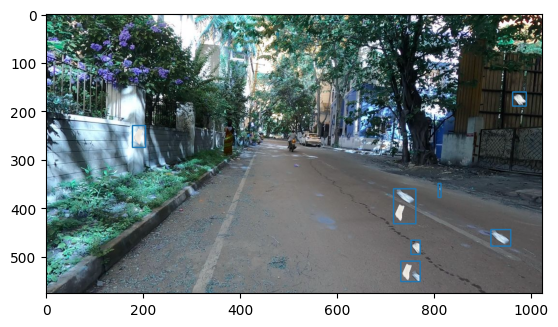

In [113]:
im = random.choice(all_images)
im = cv2.imread(im)
lbls = random_spimpose_with_cluster(im, FRAGS, 0)
draw_labels(im, lbls)

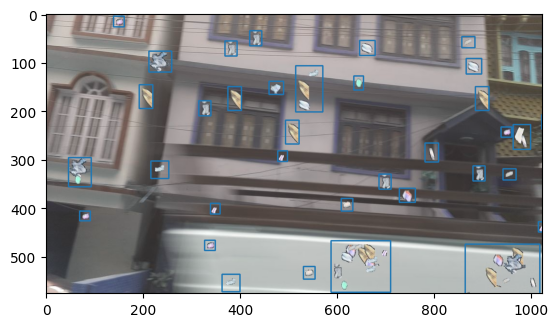

In [105]:
import cv2
imgp = "/Users/hariomnarang/Desktop/personal/roads/training/synth/images/1005.jpg"
with open("/Users/hariomnarang/Desktop/personal/roads/training/synth/labels/1005.txt") as f:
    draw_labels(cv2.imread(imgp), f.read())

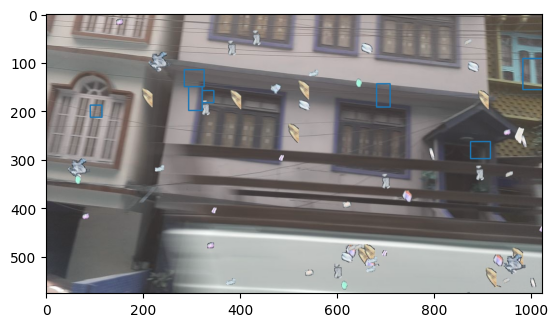

In [62]:
draw_labels(cv2.imread(corrupts[0]), lbls)

In [61]:
label_dest = Path("/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/labels")
def get_lbl_path(img_path):
    img_path = Path(img_path)
    tp = img_path.parts[-2]
    name = f"{img_path.stem}.txt"
    return label_dest / tp / name

In [19]:
get_lbl_path(corrupts[0])

PosixPath('/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/labels/train/1005.txt')

In [ ]:
label_dest = "/Users/hariomnarang/Desktop/personal/roads/training/synth_train_data/labels"

In [253]:
class RandomSampler:
    def __init__(self, images_base: Path, frags_base: Path, yolo_cls_label_id: int = 0):
        self.images = list(images_base.rglob("*.jpg"))
        self.frags = [cv2.imread(p) for p in frags_base.glob("*")]
        self._label_id = yolo_cls_label_id

    def __iter__(self):
        for p in self.images:
            img = cv2.imread(p)
            total_count = random.randint(0, 60)
            labels = random_spimpose_with_cluster(
                img, self.frags, self._label_id, total_count=total_count
            )
            yield img, labels

In [254]:
image_base = Path(
    "/Users/hariomnarang/Desktop/personal/roads/mapillary_downloader/data/samples"
)
frags_base = Path("../crops/")
sampler = RandomSampler(image_base, frags_base)

In [255]:
it = iter(sampler)

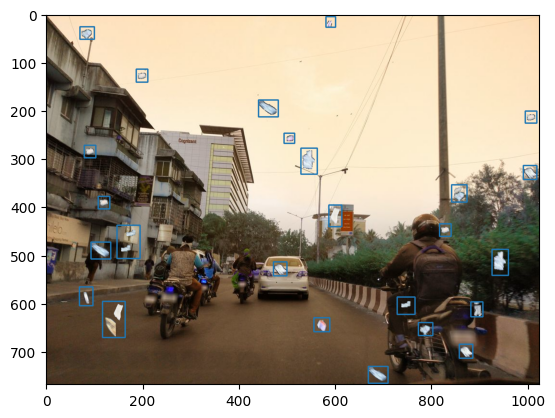

In [262]:
# plt.imshow(next(it))
i, lbl = next(it)
draw_labels(i, lbl)

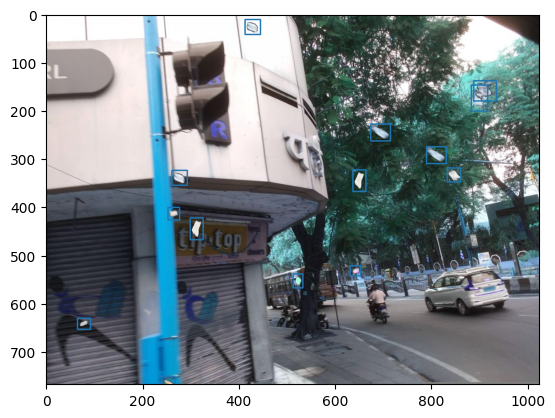

In [218]:
draw_labels(i, lbl)

## 5. Blending Techniques

Functions for seamlessly integrating fragments into backgrounds.

In [ ]:
class BlendingEngine:
    """
    Handles different blending techniques for realistic integration
    """

    @staticmethod
    def alpha_blending(
        background: np.ndarray,
        fragment: np.ndarray,
        mask: np.ndarray,
        position: Tuple[int, int],
        visualize: bool = True,
    ) -> np.ndarray:
        """
        Simple alpha blending

        Args:
            background: Background image
            fragment: Fragment to place
            mask: Alpha mask for fragment
            position: (x, y) position to place fragment

        Returns:
            Blended result
        """
        x, y = position
        fh, fw = fragment.shape[:2]
        bg_h, bg_w = background.shape[:2]

        # Ensure fragment fits in background
        if x + fw > bg_w or y + fh > bg_h:
            print(
                f"Warning: Fragment doesn't fit. Background: {bg_w}x{bg_h}, Fragment: {fw}x{fh}, Position: {x},{y}"
            )
            return background

        result = background.copy()

        # Extract region of interest
        bg_region = result[y : y + fh, x : x + fw]

        # Normalize mask to [0, 1]
        alpha = mask.astype(np.float32) / 255.0
        alpha_3d = cv2.cvtColor(alpha, cv2.COLOR_GRAY2BGR)

        # Blend
        blended_region = fragment.astype(np.float32) * alpha_3d + bg_region.astype(
            np.float32
        ) * (1 - alpha_3d)

        result[y : y + fh, x : x + fw] = blended_region.astype(np.uint8)

        if visualize:
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))

            axes[0, 0].imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
            axes[0, 0].set_title("Original Background")
            axes[0, 0].axis("off")

            axes[0, 1].imshow(cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB))
            axes[0, 1].set_title("Fragment to Place")
            axes[0, 1].axis("off")

            axes[1, 0].imshow(mask, cmap="gray")
            axes[1, 0].set_title("Alpha Mask")
            axes[1, 0].axis("off")

            axes[1, 1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            axes[1, 1].set_title("Alpha Blended Result")
            axes[1, 1].axis("off")

            # Add rectangle showing placement
            rect = Rectangle(
                (x, y), fw, fh, linewidth=2, edgecolor="red", facecolor="none"
            )
            axes[1, 1].add_patch(rect)

            plt.tight_layout()
            plt.show()

        return result

    @staticmethod
    def poisson_blending(
        background: np.ndarray,
        fragment: np.ndarray,
        mask: np.ndarray,
        position: Tuple[int, int],
        visualize: bool = True,
    ) -> np.ndarray:
        """
        Poisson blending for seamless integration
        (Requires opencv-contrib-python for cv2.seamlessClone)
        """
        try:
            x, y = position
            fh, fw = fragment.shape[:2]

            # Create center point for seamless clone
            center = (x + fw // 2, y + fh // 2)

            # Poisson blending
            result = cv2.seamlessClone(
                fragment, background, mask, center, cv2.NORMAL_CLONE
            )

            if visualize:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                axes[0].imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
                axes[0].set_title("Original Background")
                axes[0].axis("off")

                # Simple alpha blend for comparison
                alpha_result = BlendingEngine.alpha_blending(
                    background, fragment, mask, position, visualize=False
                )
                axes[1].imshow(cv2.cvtColor(alpha_result, cv2.COLOR_BGR2RGB))
                axes[1].set_title("Alpha Blending")
                axes[1].axis("off")

                axes[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
                axes[2].set_title("Poisson Blending")
                axes[2].axis("off")

                plt.tight_layout()
                plt.show()

            return result

        except Exception as e:
            print(f"Poisson blending failed: {e}")
            print("Falling back to alpha blending...")
            return BlendingEngine.alpha_blending(
                background, fragment, mask, position, visualize
            )

    @staticmethod
    def multi_scale_blending(
        background: np.ndarray,
        fragment: np.ndarray,
        mask: np.ndarray,
        position: Tuple[int, int],
        levels: int = 4,
        visualize: bool = True,
    ) -> np.ndarray:
        """
        Multi-scale (Laplacian pyramid) blending
        """
        x, y = position
        fh, fw = fragment.shape[:2]

        # Extract regions
        bg_region = background[y : y + fh, x : x + fw].copy()

        # Build Gaussian pyramids
        def build_gaussian_pyramid(img, levels):
            G = img.copy()
            gpyr = [G]
            for i in range(levels):
                G = cv2.pyrDown(G)
                gpyr.append(G)
            return gpyr

        # Build Laplacian pyramids
        def build_laplacian_pyramid(gpyr):
            lpyr = [gpyr[len(gpyr) - 1]]
            for i in range(len(gpyr) - 1, 0, -1):
                size = (gpyr[i - 1].shape[1], gpyr[i - 1].shape[0])
                GE = cv2.pyrUp(gpyr[i], dstsize=size)
                L = cv2.subtract(gpyr[i - 1], GE)
                lpyr.append(L)
            return lpyr

        # Create pyramids
        bg_gpyr = build_gaussian_pyramid(bg_region.astype(np.float32), levels)
        fg_gpyr = build_gaussian_pyramid(fragment.astype(np.float32), levels)
        mask_gpyr = build_gaussian_pyramid(mask.astype(np.float32) / 255.0, levels)

        bg_lpyr = build_laplacian_pyramid(bg_gpyr)
        fg_lpyr = build_laplacian_pyramid(fg_gpyr)

        # Blend pyramids
        blended_lpyr = []
        for bg_l, fg_l, mask_l in zip(bg_lpyr, fg_lpyr, mask_gpyr):
            mask_3d = cv2.merge([mask_l, mask_l, mask_l])
            blended = fg_l * mask_3d + bg_l * (1 - mask_3d)
            blended_lpyr.append(blended)

        # Reconstruct from pyramid
        blended_region = blended_lpyr[0]
        for i in range(1, len(blended_lpyr)):
            size = (blended_lpyr[i].shape[1], blended_lpyr[i].shape[0])
            blended_region = cv2.pyrUp(blended_region, dstsize=size)
            blended_region = cv2.add(blended_region, blended_lpyr[i])

        # Place back in background
        result = background.copy().astype(np.float32)
        result[y : y + fh, x : x + fw] = blended_region
        result = np.clip(result, 0, 255).astype(np.uint8)

        if visualize:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Simple alpha blend for comparison
            alpha_result = BlendingEngine.alpha_blending(
                background, fragment, mask, position, visualize=False
            )
            axes[0].imshow(cv2.cvtColor(alpha_result, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Alpha Blending")
            axes[0].axis("off")

            axes[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            axes[1].set_title("Multi-scale Blending")
            axes[1].axis("off")

            # Difference
            diff = cv2.absdiff(alpha_result, result)
            axes[2].imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
            axes[2].set_title("Difference")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

        return result

## 6. Complete Pipeline

Putting it all together in an easy-to-use pipeline.

In [ ]:
class FragmentSuperpositionPipeline:
    """
    Complete pipeline for realistic fragment superposition
    """

    def __init__(self):
        self.bg_analyzer = BackgroundAnalyzer()
        self.fragment_processor = FragmentProcessor()
        self.geometric_aligner = GeometricAligner()
        self.photometric_matcher = PhotometricMatcher()
        self.blending_engine = BlendingEngine()

    def process_single_placement(
        self,
        background: np.ndarray,
        fragment: np.ndarray,
        position: Tuple[int, int] = None,
        scale: float = None,
        rotation: float = None,
        blend_method: str = "alpha",
        visualize_steps: bool = True,
    ) -> np.ndarray:
        """
        Complete pipeline for placing one fragment

        Args:
            background: Background street image
            fragment: Garbage fragment image
            position: (x, y) placement position (None = auto-find)
            scale: Scale factor (None = auto-estimate)
            rotation: Rotation in degrees (None = random)
            blend_method: 'alpha', 'poisson', or 'multiscale'
            visualize_steps: Show intermediate results

        Returns:
            Final composited image
        """
        print("🔍 Step 1: Analyzing background...")
        placement_mask = self.bg_analyzer.simple_color_segmentation(
            background, visualize_steps
        )
        sky_mask = self.bg_analyzer.detect_sky_region(background, visualize_steps)

        # Exclude sky from placement
        placement_mask = cv2.bitwise_and(placement_mask, cv2.bitwise_not(sky_mask))

        print("🎨 Step 2: Processing fragment...")
        clean_fragment, alpha_mask = self.fragment_processor.simple_background_removal(
            fragment, method="grabcut", visualize=visualize_steps
        )
        clean_fragment, alpha_mask = self.fragment_processor.refine_fragment_edges(
            clean_fragment, alpha_mask, visualize=visualize_steps
        )

        print("📐 Step 3: Geometric alignment...")

        # Auto-find position if not provided
        if position is None:
            fh, fw = clean_fragment.shape[:2]
            valid_points = self.geometric_aligner.find_valid_placement_points(
                placement_mask, (fh, fw), num_points=1, visualize=visualize_steps
            )
            if not valid_points:
                print("❌ No valid placement points found!")
                return background
            position = valid_points[0]

        # Auto-estimate scale if not provided
        if scale is None:
            scale = self.geometric_aligner.estimate_ground_scale(
                background.shape[:2], position[1], visualize=visualize_steps
            )

        # Random rotation if not provided
        if rotation is None:
            rotation = random.uniform(-15, 15)

        # Apply transformations
        transformed_fragment, transformed_mask = (
            self.geometric_aligner.transform_fragment(
                clean_fragment, alpha_mask, scale, rotation, visualize=visualize_steps
            )
        )

        print("💡 Step 4: Photometric matching...")

        # Analyze lighting in placement region
        x, y = position
        fh, fw = transformed_fragment.shape[:2]
        region_mask = np.zeros_like(placement_mask)
        region_mask[
            y : min(y + fh, region_mask.shape[0]), x : min(x + fw, region_mask.shape[1])
        ] = 255

        lighting_info = self.photometric_matcher.analyze_lighting(
            background, region_mask, visualize=visualize_steps
        )

        # Match fragment lighting
        lit_fragment = self.photometric_matcher.match_fragment_lighting(
            transformed_fragment, lighting_info, visualize=visualize_steps
        )

        # Generate shadow
        shadow_mask = self.photometric_matcher.generate_simple_shadow(
            transformed_mask, shadow_offset=(3, 3), visualize=visualize_steps
        )

        print("🎭 Step 5: Blending...")

        # Apply shadow first
        result = background.copy()
        shadow_region = result[y : y + fh, x : x + fw]
        shadow_alpha = shadow_mask.astype(np.float32) / 255.0
        shadow_alpha_3d = cv2.cvtColor(shadow_alpha, cv2.COLOR_GRAY2BGR)
        darkened = shadow_region * (1 - shadow_alpha_3d * 0.3)  # Darken by 30%
        result[y : y + fh, x : x + fw] = darkened.astype(np.uint8)

        # Blend fragment
        if blend_method == "alpha":
            final_result = self.blending_engine.alpha_blending(
                result,
                lit_fragment,
                transformed_mask,
                position,
                visualize=visualize_steps,
            )
        elif blend_method == "poisson":
            final_result = self.blending_engine.poisson_blending(
                result,
                lit_fragment,
                transformed_mask,
                position,
                visualize=visualize_steps,
            )
        else:  # multiscale
            final_result = self.blending_engine.multi_scale_blending(
                result,
                lit_fragment,
                transformed_mask,
                position,
                visualize=visualize_steps,
            )

        print("✅ Pipeline complete!")
        return final_result

## 7. Example Usage and Experiments

Demonstration of how to use the pipeline and experiment with different parameters.

In [ ]:
def create_sample_images():
    """Create sample images for testing if no real images are available"""

    # Sample background (street scene)
    background = np.ones((400, 600, 3), dtype=np.uint8) * 50  # Dark base

    # Add road (gray horizontal strip)
    cv2.rectangle(background, (0, 200), (600, 300), (80, 80, 80), -1)

    # Add some texture noise
    noise = np.random.randint(-20, 20, background.shape).astype(np.int16)
    background = np.clip(background.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # Add sky (blue upper portion)
    cv2.rectangle(background, (0, 0), (600, 150), (200, 150, 50), -1)

    # Sample fragment (bright object)
    fragment = np.ones((60, 80, 3), dtype=np.uint8) * 100  # Gray base
    cv2.ellipse(
        fragment, (40, 30), (25, 20), 0, 0, 360, (255, 255, 255), -1
    )  # White ellipse
    cv2.ellipse(
        fragment, (40, 30), (20, 15), 0, 0, 360, (0, 200, 255), -1
    )  # Orange center

    return background, fragment


def experiment_with_pipeline():
    """
    Demonstrate the complete pipeline with various experiments
    """
    print("=== Fragment Superposition Pipeline Experiment ===\n")

    # Create or load sample images
    print("Creating sample images (replace with real images)...")
    background, fragment = create_sample_images()

    # Initialize pipeline
    pipeline = FragmentSuperpositionPipeline()

    print("\n1. Basic placement with auto-settings...")
    result1 = pipeline.process_single_placement(
        background, fragment, visualize_steps=True
    )

    print("\n2. Manual placement with specific parameters...")
    result2 = pipeline.process_single_placement(
        background,
        fragment,
        position=(300, 220),  # Specific position
        scale=1.2,  # Larger scale
        rotation=25,  # Rotated
        blend_method="poisson",
        visualize_steps=True,
    )

    print("\n3. Multiple placements...")
    current_bg = background.copy()

    for i in range(3):
        print(f"\nPlacement {i + 1}/3...")
        current_bg = pipeline.process_single_placement(
            current_bg,
            fragment,
            scale=0.8 + i * 0.3,  # Varying scales
            visualize_steps=False,  # Less verbose for multiple
        )

    # Final comparison
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
    plt.title("Original Background")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title("Auto Placement")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title("Manual Placement")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(current_bg, cv2.COLOR_BGR2RGB))
    plt.title("Multiple Placements")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Example function to load your own images
def load_your_images():
    """
    Template function for loading your real images
    Modify paths to point to your actual images
    """
    # Replace these paths with your actual image paths
    background_path = "path/to/your/street_image.jpg"
    fragment_path = "path/to/your/garbage_fragment.jpg"

    try:
        background = cv2.imread(background_path)
        fragment = cv2.imread(fragment_path)

        if background is None or fragment is None:
            print("Could not load images - using sample images instead")
            return create_sample_images()

        print(f"Loaded background: {background.shape}")
        print(f"Loaded fragment: {fragment.shape}")
        return background, fragment

    except Exception as e:
        print(f"Error loading images: {e}")
        return create_sample_images()

## 8. Running the Experiments

Execute this section to see all the techniques in action!

In [ ]:
if __name__ == "__main__":
    # Run the complete experiment
    experiment_with_pipeline()

    # You can also test individual components:
    print("\n" + "=" * 50)
    print("Testing individual components...")

    # Test background analysis
    background, fragment = create_sample_images()
    analyzer = BackgroundAnalyzer()

    print("\n🔍 Background Analysis:")
    placement_mask = analyzer.simple_color_segmentation(background)
    sky_mask = analyzer.detect_sky_region(background)

    # Test fragment processing
    print("\n🎨 Fragment Processing:")
    processor = FragmentProcessor()
    clean_fragment, mask = processor.simple_background_removal(
        fragment, method="threshold"
    )

    # Test geometric alignment
    print("\n📐 Geometric Alignment:")
    aligner = GeometricAligner()
    scale = aligner.estimate_ground_scale(background.shape[:2], 250)
    transformed_fragment, transformed_mask = aligner.transform_fragment(
        clean_fragment, mask, scale=scale, rotation=15
    )

    # Test photometric matching
    print("\n💡 Photometric Matching:")
    matcher = PhotometricMatcher()
    lighting_info = matcher.analyze_lighting(background)
    lit_fragment = matcher.match_fragment_lighting(transformed_fragment, lighting_info)

    print("\nAll individual tests completed! ✅")